#### 01_demo.ipynb

- More demos showing how we work with diffent operators
- At the end of this notebook there is 2D CS(Sparse) Fourier Reconstrustruction Example where I concatenate several linear operators provided by this package

In [61]:
using MiniOps
using LinearAlgebra
using Plots, FFTW

In [62]:
# Test that 1D convolution and its adjoint (on the flight) pass the dot product test

function test_conv()

    h = randn(15)
    A = conv1d_op(h)

    x1 = randn(120) 
    y1 = A*x1
    
    y2 = randn(size(y1))
    x2 = A'*y2

println("<y1, y2> - <x1, x2>: ", y1'*y2 -x2'*x1)
println(A.name, " size : ", A.m, A.n)

end

test_conv()

<y1, y2> - <x1, x2>: -1.3322676295501878e-14
conv1d size : -1-1


In [63]:
# Test composition (concatenation) of several linear operators 

function test_composition()

  println("Testing do-product for A = S1*R*S2")
  println("S1 is scaling")
  println("S2 applies diag weights")
  println("R is sampling")

    nx, ny = 20, 30
    full_size = (nx, ny)
    mask = rand(nx * ny) .> 0.7
    idx  = findall(mask)
    R = sampling_op(idx, full_size)

    S1 = scaling_op(3.0)
    S2 = diag_op(ones(nx,ny))

    A = S1*R*S2
    
    x1 = randn(nx, ny)
    y1 = A*x1

    y2 = randn(size(y1))
    x2 = A'*y2

println("<x1,x2> = ", dot(x1,x2))
println("<y1,y2> = ", dot(y2,y1))
println("name = ", A.name, " Size: ",  A.m, A.n)
end
    
test_composition()

Testing do-product for A = S1*R*S2
S1 is scaling
S2 applies diag weights
R is sampling
<x1,x2> = -16.215275368037947
<y1,y2> = -16.215275368037947
name = scaling*sampling*diag Size: -1-1


In [64]:
# Multiple dispatch is used to generate two FFT operators (size planned and size unplanned)

A = fft_op(randn(ComplexF64,20,20))
B = fft_op()

x1 = randn(ComplexF64,20,20)
y1 = A*x1

y2 = randn(ComplexF64,20,20)
x2 = A'*y2

println("<x1,x2> = ", round(dot(x1,x2), digits=8))
println("<y1,y2> = ", round(dot(y1,y2), digits=8))

A = with_shape(A, x1)
println(  "m : ", A.name,  " n : ", A.n)
println(  "m : ", B.name,  " n : ", B.n)

B = with_shape(B, x1)
println(  "m : ", B.name,  " n : ", B.n)

<x1,x2> = 20.47702218 + 4.25612316im
<y1,y2> = 20.47702218 + 4.25612316im
m : fft_planned n : 400
m : fft_op n : -1
m : fft_op n : 400


In [65]:
# Dot product test for the multichannel convolution and it's adjoint 
function test_conv_multichannel()

    wavelet = rand(10)
    A = conv1d_cols_op(wavelet)

    x1 = randn(200,100)
    y1 = A*x1

    y2 = randn(size(y1))
    x2 = A'*y2

println("<x1,x2> = ", dot(x1,x2))
println("<y1,y2> = ", dot(y1,y2))
    
println("name : ", A.name," m : ", A.m, " n : ", A.n)
B = with_shape(A, x1)
println("name : ", B.name," m : ", B.m, " n : ", B.n)
end
test_conv_multichannel()

<x1,x2> = 122.96597979502323
<y1,y2> = 122.9659797950232
name : conv1d_cols m : -1 n : -1
name : conv1d_cols m : 20900 n : 20000


### 2D Fourier Reconstruction
We solve 
$$\mathrm{argmin_{
c} \,} \{ J = \| A c - y\|_2^2 + \lambda_1 \| c\|_1 \}$$

where

- $c$ : DFT 2D coefficients
- $A$ : $RP'F$: Forward operator
- $R$ : Sampling
- $P'$ : Adjoint of padding (truncation)
- $F$ : DFT (FFT) 2D operator
once $c$ is estimated from $y$, we synthetize complete data via $x = P'F c$. The operator $P$ is
zero padding which is used to increase the number of wave-number domain samples in the DFT.

In [66]:
# Demo showing Fourier 2D Reconstruction with Sparsity Constraints  
# ----------------------------------------------------------------
#
# Solve || A c - y ||_2^2 + λ ||c||_1 where y = R x, x is desired data (2D) and y is 
# data measured. c are 2D DFT coefficients. 

# Adjoint c= F'PR'y 
# Forwadd y = R P' Fc

# F: Fourier synthetis operator (fft_op)
# P: Padding operator (pad_op)
# R: Sampling operator 

nx,  ny  = 100, 100
nkx, nky = 256, 256
p1,  p2  = (nkx-nx)÷2,(nky-ny)÷2

full_size = (nx, ny)
mask = rand(nx * ny) .> 0.8
idx  = findall(mask)
    
R = sampling_op(idx, full_size) 

# True DFT coefficients

c = zeros(ComplexF64, nkx, nky)
F = fft_op(c)
c[4,5] = 3.0 - im*3.0; c[2,6]   = 2.0 - im*3.0; x[2, 251] = 2.0 - im*3.0
c[5,251] = 1.2 - im*3.0 ;c[253,2] = 1.0 - im*3.0; x[251,252] = 2.0 - im*2.0

P = pad_op((nx,ny),(p1,p2),(p1,p2))
A = R*P'*F
# Data to reconstruct 
y = A*c

# Inverse DFT coefficients and then use them to reconstruct the data 

ci = randn(ComplexF64,nkx,nky)
e = opnorm_power(A,ci)
μ = 0.02
ν = 0.98/e^2
ci = ista(A, y, u0, μ, ν; niter=900, verbose=false);



In [70]:
# Demo showing Fourier 2D Reconstruction with Sparsity Constraints  
# ----------------------------------------------------------------
#
# Solve || A c - y ||_2^2 + λ ||c||_1 where y = R x, x is desired data (2D) and y is 
# data measured. c are 2D DFT coefficients. 

# Adjoint c= F'PR'y 
# Forwadd y = R P' Fc

# F: Fourier synthetis operator (fft_op)
# P: Padding operator (pad_op)
# R: Sampling operator 

nx,  ny  = 100, 100
nkx, nky = 256, 256
p1,  p2  = (nkx-nx)÷2,(nky-ny)÷2

full_size = (nx, ny)
mask = rand(nx * ny) .> 0.8
idx  = findall(mask)
    
R = sampling_op(idx, full_size) 

# True DFT coefficients

c = zeros(ComplexF64, nkx, nky)
F = fft_op(c)
c[4,5] = 3.0 - im*3.0; c[2,6]   = 2.0 - im*3.0; x[2, 251] = 2.0 - im*3.0
c[5,251] = 1.2 - im*3.0 ;c[253,2] = 1.0 - im*3.0; x[251,252] = 2.0 - im*2.0

P = pad_op((nx,ny),(p1,p2),(p1,p2))
A = R*P'*F
# Data to reconstruct 
y = A*c

# Inverse DFT coefficients and then use them to reconstruct the data 

ci = randn(ComplexF64,nkx,nky)
e = opnorm_power(A,ci)
μ = 0.02
ν = 0.98/e^2
ci = ista(A, y, u0, μ, ν; niter=900, verbose=false);



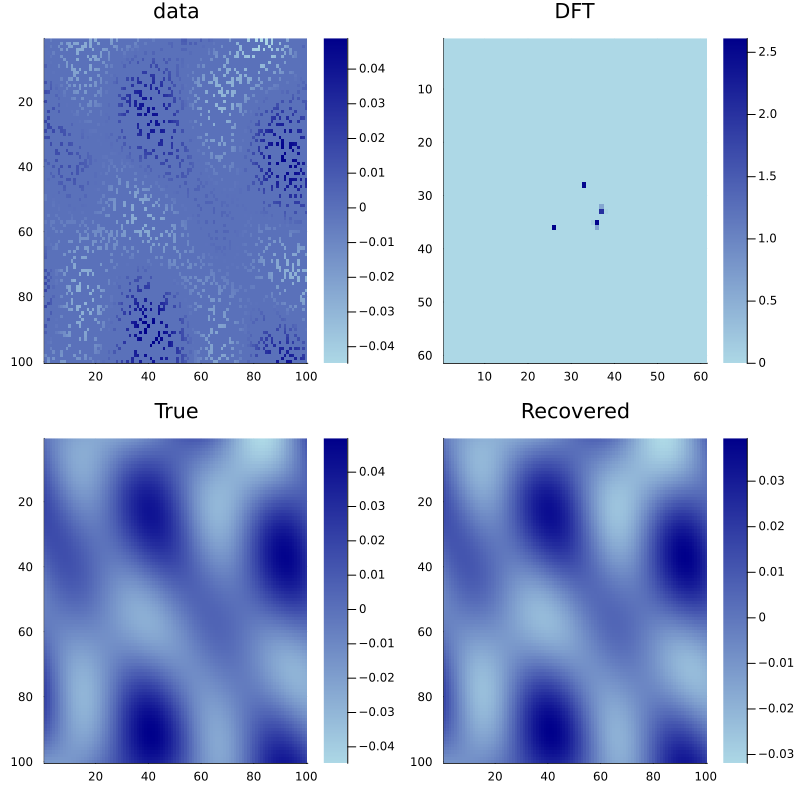

In [71]:

p1 = heatmap(real.(R'*y), cmap=:blues, yflip=true, title="data")
p2 = heatmap((fftshift(abs.(ci))[128-30:128+30,128-30:128+30]),  cmap=:blues, yflip=true, title="DFT")
p3 = heatmap(real.(P'*F*c), cmap=:blues, yflip=true, title="True")
p4 = heatmap(real.(P'*F*ci),  cmap=:blues, yflip=true, title="Recovered")
plot(p1, p2, p3, p4, layout = (2,2), size=(800,800))

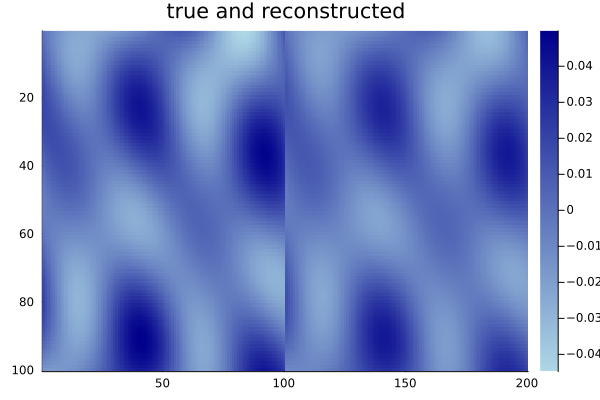

In [69]:
heatmap(hcat(real.(P'*F*c),real.(P'*F*ci)),  cmap=:blues, yflip=true, title="true and reconstructed")